C:\Users\sagni\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


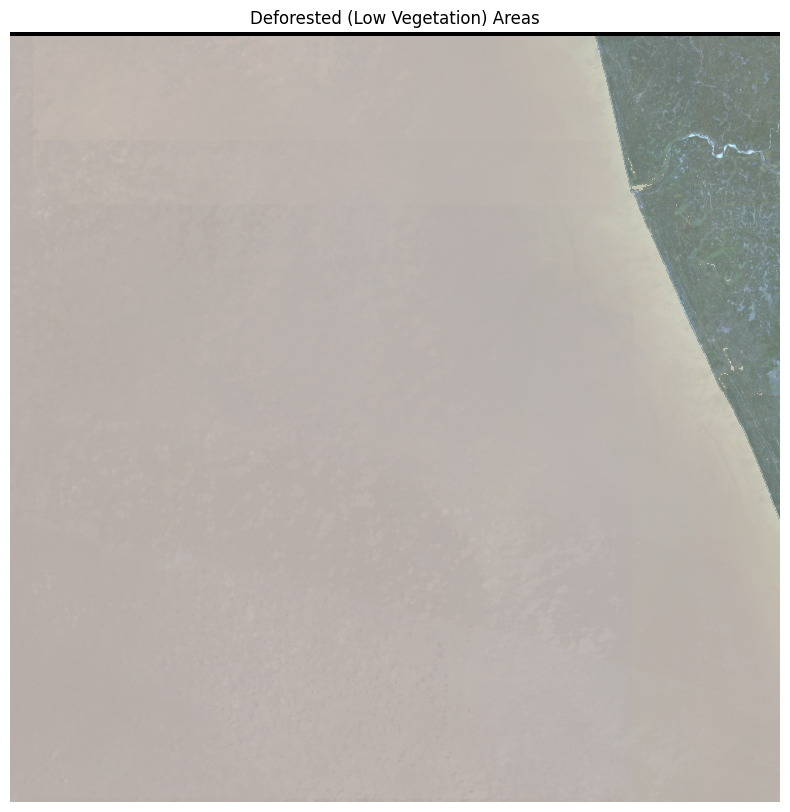

Deforested Area 1: Centroid at (Lon: 75.87036, Lat: 11.00001)
Deforested Area 2: Centroid at (Lon: 75.87274, Lat: 11.00001)
Deforested Area 3: Centroid at (Lon: 75.89003, Lat: 11.00001)
Deforested Area 4: Centroid at (Lon: 75.89152, Lat: 11.00001)
Deforested Area 5: Centroid at (Lon: 75.89489, Lat: 11.00001)


In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_image
from rasterio.features import shapes
from shapely.geometry import shape

# === STEP 1: Load Sentinel-2 Image ===
tif_path = r"C:\Users\sagni\Downloads\Deforestation Detection\Western_Ghats_After_2022-0000000000-0000011776.tif"

with rasterio.open(tif_path) as src:
    red = src.read(3).astype(np.float32)   # B4 (Red)
    green = src.read(2).astype(np.float32) # B3 (Green)
    blue = src.read(1).astype(np.float32)  # B2 (Blue)
    nir = src.read(4).astype(np.float32)   # B8 (NIR)
    transform = src.transform
    profile = src.profile

# === STEP 2: Compute NDVI ===
ndvi = (nir - red) / np.maximum(nir + red, 1e-5)
ndvi = np.clip(ndvi, -1, 1)

# === STEP 3: Detect Low NDVI Areas (Deforested) ===
threshold = 0.3
deforestation_mask = (ndvi < threshold).astype(np.uint8)

# === STEP 4: Visualize with Red Overlay ===
# Normalize RGB image for visualization
rgb = np.stack([red, green, blue], axis=-1)
rgb = np.clip(rgb, 0, 3000) / 3000.0  # Sentinel-2 reflectance range

plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.imshow(np.ma.masked_where(deforestation_mask == 0, deforestation_mask), cmap='Reds', alpha=0.5)
plt.title("Deforested (Low Vegetation) Areas")
plt.axis('off')
plt.show()

# === STEP 5: Save Mask as GeoTIFF (Optional) ===
def save_mask(mask, profile, output_path):
    profile.update(dtype=rasterio.uint8, count=1)
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(mask.astype(np.uint8), 1)

save_mask(deforestation_mask, profile, "deforestation_mask.tif")

# === STEP 6: Extract Coordinates of Deforested Areas (Optional) ===
def get_polygons_from_mask(mask, transform):
    shapes_gen = shapes(mask, mask=mask.astype(bool), transform=transform)
    polygons = []
    for geom, val in shapes_gen:
        if val == 1:
            polygons.append(shape(geom))
    return polygons

polygons = get_polygons_from_mask(deforestation_mask, transform)

# Print first 5 deforested areas (centroids or bounds)
for i, poly in enumerate(polygons[:5]):
    lon, lat = poly.centroid.x, poly.centroid.y
    print(f"Deforested Area {i+1}: Centroid at (Lon: {lon:.5f}, Lat: {lat:.5f})")
